In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [31]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [37]:
# Create our session (link) from Python to the DB
session = Session(engine)

query_m = session.query(Measurement.station, Measurement.date).all()
session.close()
df_m = pd.DataFrame(query_m, columns=["station", "date"])
print(df_m)

           station        date
0      USC00519397  2010-01-01
1      USC00519397  2010-01-02
2      USC00519397  2010-01-03
3      USC00519397  2010-01-04
4      USC00519397  2010-01-06
...            ...         ...
19545  USC00516128  2017-08-19
19546  USC00516128  2017-08-20
19547  USC00516128  2017-08-21
19548  USC00516128  2017-08-22
19549  USC00516128  2017-08-23

[19550 rows x 2 columns]


In [34]:
#session = Session(engine)
#query_s = session.query(Station.station, Station.name).all()
#session.close()
#df_s = pd.DataFrame(query_s, columns=["station", "name"])
#print(df_s)

       station                                    name
0  USC00519397                    WAIKIKI 717.2, HI US
1  USC00513117                    KANEOHE 838.1, HI US
2  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US
3  USC00517948                       PEARL CITY, HI US
4  USC00518838              UPPER WAHIAWA 874.3, HI US
5  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US
6  USC00519281                     WAIHEE 837.5, HI US
7  USC00511918       HONOLULU OBSERVATORY 702.2, HI US
8  USC00516128            MANOA LYON ARBO 785.2, HI US


# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date.date

'2017-08-23'

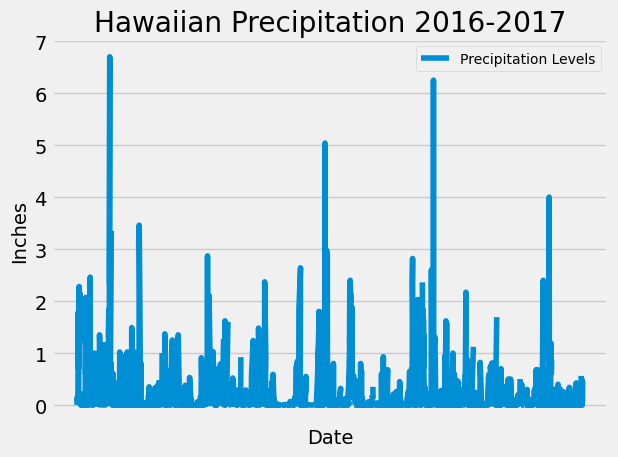

In [96]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

recent_data = pd.to_datetime(recent_date.date)
year_leap = recent_data - timedelta(days=365)

first_date = dt.date(year_leap.year, year_leap.month, year_leap.day)
last_date = dt.date(recent_data.year, recent_data.month, recent_data.day)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date).order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_df = pd.DataFrame(data, columns=['date', 'prcp'])

# Sort the dataframe by date
data_df = data_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
data_df.plot()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks([])
plt.title("Hawaiian Precipitation 2016-2017")
plt.legend(["Precipitation Levels"], loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()


In [94]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_stats = data_df['prcp'].describe()
prcp_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [97]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
total_stations

9

In [110]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

stations_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in stations_count:
    print(f"Station: {station}, Rows: {count}")

most_active_station = stations_count[0][0]

print(f"The most active station is: {stations_count[0][0]}")

Station: USC00519281, Rows: 2772
Station: USC00519397, Rows: 2724
Station: USC00513117, Rows: 2709
Station: USC00519523, Rows: 2669
Station: USC00516128, Rows: 2612
Station: USC00514830, Rows: 2202
Station: USC00511918, Rows: 1979
Station: USC00517948, Rows: 1372
Station: USC00518838, Rows: 511
The most active station is: USC00519281


In [111]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stats= session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
stats

[(54.0, 85.0, 71.66378066378067)]

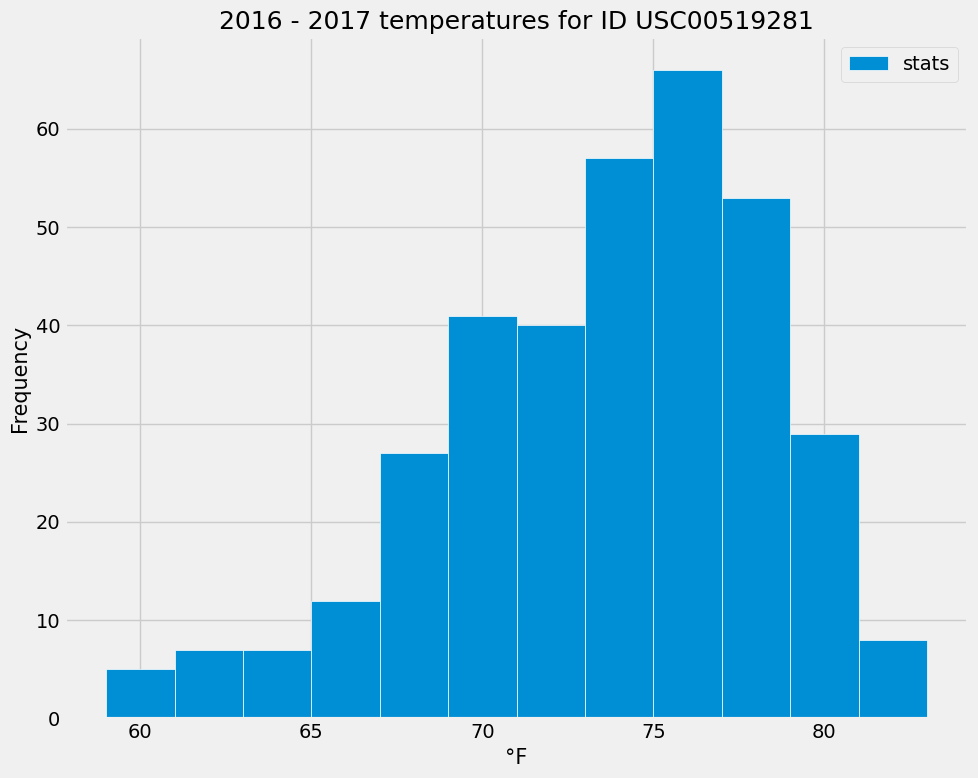

In [128]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

id_year_temp = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= first_date).filter(Measurement.date <= last_date).filter(Measurement.station == most_active_station).all()

id_year_temp_df = pd.DataFrame(id_year_temp, columns=["Date","Stats"])
id_year_temp_df = id_year_temp_df.set_index("Date")

id_year_temp_df.sort_values(by="Date")
id_year_temp_df.head()

plt.figure(figsize=(10,8))
plt.hist(id_year_temp_df["Stats"].values, bins=12, edgecolor="white")
plt.legend(["stats"], loc="upper right")
plt.ylabel("Frequency", size=15)
plt.xlabel("°F", size=15)
plt.title(f"2016 - 2017 temperatures for ID {most_active_station}", size=18)
plt.tight_layout()
plt.show()

# Close Session

In [129]:
# Close Session
session.close()